### Using AlexNet Pretrained model in Pytorch for CIFAR-10 Image Classification

+ This notebook shows how to use PyTorch AlexNet pretrained model for image classification.  

+ The dataset used is CIFAR-10. 

+ CIFAR-10 defines 10 classes and contains 6K images per class, for a total of 60K images. 

+ 50K Images are used for training and 10K for testing.

+ The images are (32,32) RGBs

        + https://www.cs.toronto.edu/~kriz/cifar.html

+ Images are obtained directly from torchvision.datasets.CIFAR10(args) 

+ The last cells show how to evaluate the model in general and also there is a cell where the model performance is valuated in terms of each of the 10 classes.

+ The code shows how to connect the model to the GPU, and how to ensure that the data is also loaded into the GPU




In [1]:
# Get general purpose APIs first
import numpy as np
import matplotlib.pyplot as plt

# load the Pytorch APIs
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# 1. Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(224),  # AlexNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# 2. Load Pretrained AlexNet
model = torchvision.models.alexnet(pretrained=True)

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10) # 10 output classes

# model = model().to(device)

In [6]:
# 3. Modify the final fully connected layer
# AlexNet was trained on ImageNet, which has 1000 classes.
# CIFAR-10 has 10 classes, so we need to change the output layer.

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 10) # 10 output classes

In [7]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_params( model )

In [6]:
# 4. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
# 5. Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        # Ensure labels are long type
        labels = labels.long()
        loss = criterion(outputs, labels) # Corrected order: outputs, labels
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.367
[1,  4000] loss: 0.923
[1,  6000] loss: 0.801
[1,  8000] loss: 0.726
[1, 10000] loss: 0.698
[1, 12000] loss: 0.665
[2,  2000] loss: 0.555
[2,  4000] loss: 0.545
[2,  6000] loss: 0.542
[2,  8000] loss: 0.521
[2, 10000] loss: 0.536
[2, 12000] loss: 0.526
Finished Training


In [9]:
# 7. Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')

Accuracy of the network on the 10000 test images: 78.12 %


In [10]:

# 8. Class-wise accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f} %')

Accuracy of plane : 70.30 %
Accuracy of car   : 88.10 %
Accuracy of bird  : 69.00 %
Accuracy of cat   : 56.10 %
Accuracy of deer  : 79.00 %
Accuracy of dog   : 75.80 %
Accuracy of frog  : 81.80 %
Accuracy of horse : 83.80 %
Accuracy of ship  : 97.20 %
Accuracy of truck : 77.10 %


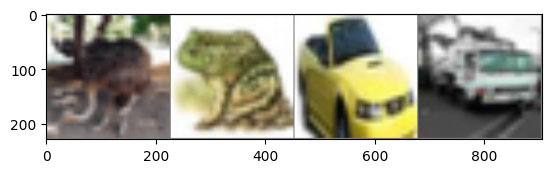

 bird || frog || car || truck


In [11]:
def imageshow(image):
   # un-normalize the image
   image = image/2 + 0.5
   npimage = image.numpy()
   plt.imshow(np.transpose(npimage, (1, 2, 0)))
   plt.show()

# sample images from training set
dataiter = iter(trainloader)
images, labels = next(dataiter)
# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print(' ' + ' || '.join(classes[labels[j]]
        for j in range(num_images)))



In [12]:
count_params( model ) 

57044810